<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/waves/ptychographyResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolution and Fourier Ptychography
## David Brady
## University of Arizona
## October 2021

This notebook considers point target imaging with ptychographic imaging as discussed in section 5.11 of *Computational Imaging*.

### Python Libraries

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from joblib import Parallel, delayed
import time
from skimage import exposure, filters
from skimage.metrics import structural_similarity as ssim
from scipy.special import j1
from google.colab import files
plt.rcParams.update({'font.size': 22})

In [58]:
def airy(x):
  ai = 2*j1(np.pi*x) /(np.pi*x)
  return ai
airv=np.vectorize(airy)

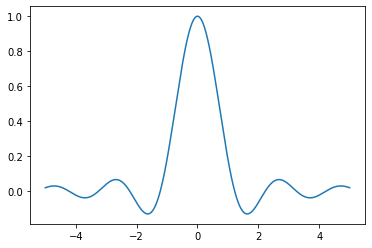

In [36]:
xrange=np.linspace(-5,5,1024)
plt.plot(xrange,airy(xrange))

We are interested in the pattern detected when a pair of remote points separated by distance $2x_o$ are illuminated by a plane wave with spatial frequency $u$.  We are interested in separations $2x_o<\lambda f/\#$. Effective illumination spatial freuquencies, in contrast, are  $u<\frac{2Z}{\lambda F}$, where $z$ is the target range. 

In [60]:
def twoPointSignal(x,xo,u):
  tps=np.abs(airv(x-xo)*np.exp(2*np.pi*1j*u*xo)+airv(x+xo)*np.exp(-2*np.pi*1j*u*xo))**2
  return tps
tpv=np.vectorize(twoPointSignal)

# two point separated by n $\lambda f/\#$

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

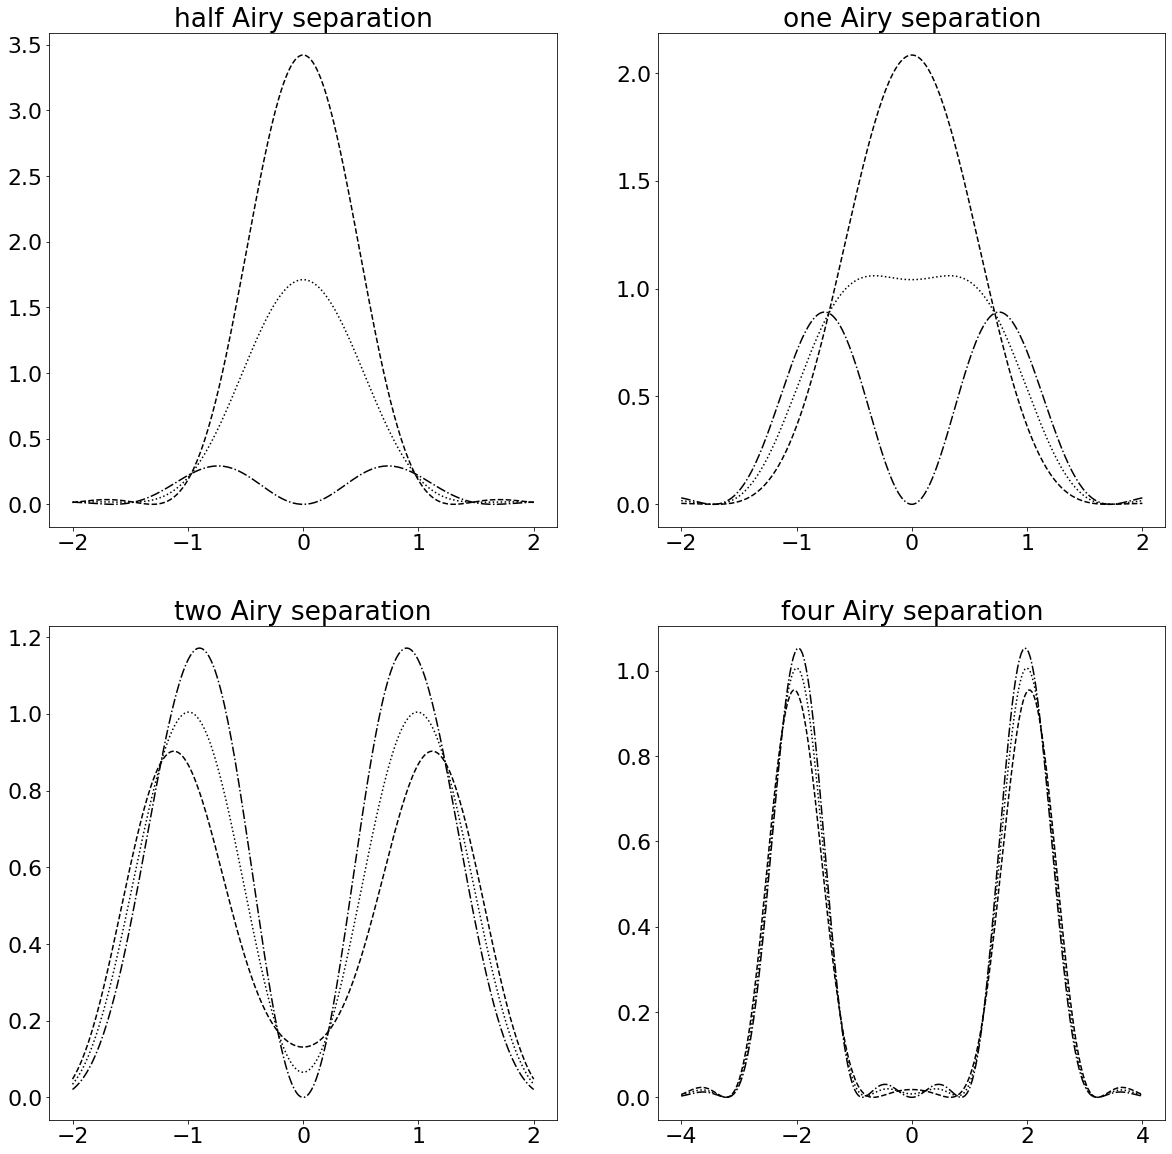

In [121]:
plt.figure(figsize=(20,20))
xo=.25
xrange=np.linspace(-2,2,256)
plt.subplot(2,2,1)
plt.plot(xrange, tpv(xrange,xo,0),'k--',xrange, tpv(xrange,xo,.5),'k:',xrange, tpv(xrange,xo,1),'k-.')
plt.title('half Airy separation')
xo=.5
xrange=np.linspace(-2,2,256)
plt.subplot(2,2,2)
plt.plot(xrange, tpv(xrange,xo,0),'k--',xrange, tpv(xrange,xo,.25),'k:',xrange, tpv(xrange,xo,.5),'k-.')
plt.title('one Airy separation')
xo=1
xrange=np.linspace(-2,2,256)
plt.subplot(2,2,3)
plt.plot(xrange, tpv(xrange,xo,0),'k--',xrange, tpv(xrange,xo,.125),'k:',xrange, tpv(xrange,xo,.25),'k-.')
plt.title('two Airy separation')
xo=2
xrange=np.linspace(-4,4,256)
plt.subplot(2,2,4)
plt.plot(xrange, tpv(xrange,xo,0),'k--',xrange, tpv(xrange,xo,.067),'k:',xrange, tpv(xrange,xo,.125),'k-.')
plt.title('four Airy separation')
plt.savefig('twoPointFP.pdf')
files.download('twoPointFP.pdf')

Text(0.5, 1.0, 'two wave separation')

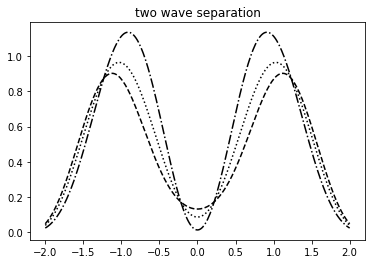

In [105]:
xo=1
xrange=np.linspace(-2,2,256)
xo=1
plt.plot(xrange, tpv(xrange,xo,0),'k--',xrange, tpv(xrange,xo,.1),'k:',xrange, tpv(xrange,xo,.7),'k-.')
plt.title('two wave separation')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

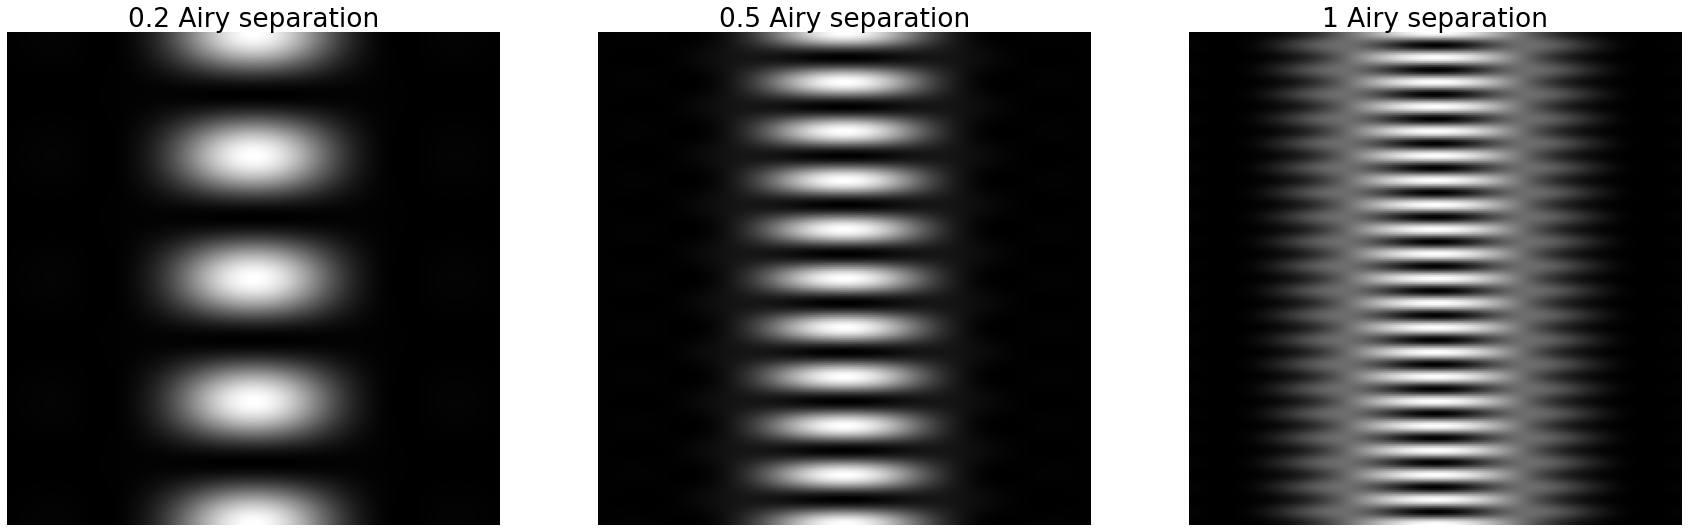

In [122]:
plt.figure(figsize=(30,10))
xo=.1
urange=np.linspace(-10,10,256)
xrange=np.linspace(-2,2,256)
xr, ur=np.meshgrid(xrange,urange)
plt.subplot(1,3,1)
plt.imshow(tpv(xr,xo,ur),cmap='gray')
plt.title('0.2 Airy separation')
plt.axis('off')
xo=.25
urange=np.linspace(-10,10,256)
xrange=np.linspace(-2,2,256)
xr, ur=np.meshgrid(xrange,urange)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(tpv(xr,xo,ur),cmap='gray')
plt.title('0.5 Airy separation')
xo=.5
urange=np.linspace(-10,10,256)
xrange=np.linspace(-2,2,256)
xr, ur=np.meshgrid(xrange,urange)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(tpv(xr,xo,ur),cmap='gray')
plt.title('1 Airy separation')
plt.savefig('twoPointFPDensity.pdf')
files.download('twoPointFPDensity.pdf')

### Numerical demonstration of the airy pattern

In [37]:
def rect(x):
  rc=(1-np.sign(x-.5))/2.
  return rc

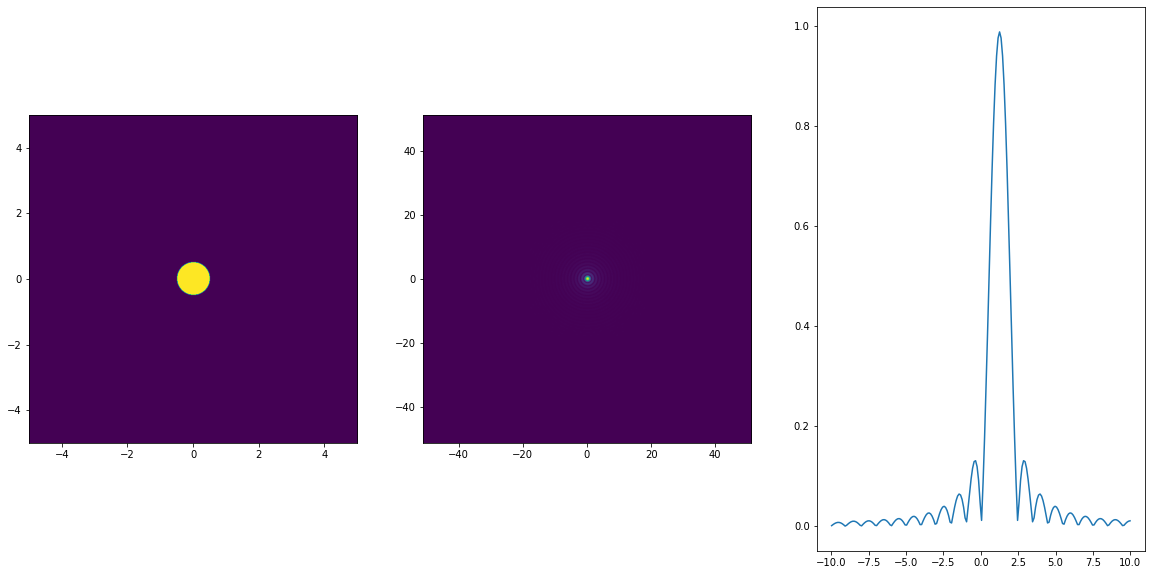

In [50]:
xr=np.linspace(-5,5,1024)
x,y =np.meshgrid(xr,xr)
disk=rect(np.sqrt(x**2+y**2))
plt.figure(figsize = (20,10))
plt.subplot(1,3,1)
plt.imshow(disk,extent=[-5,5,-5,5])
plt.subplot(1,3,2)
dx=xr[1]-xr[0]
B=1./(2*dx)
airy=np.fft.fftshift(np.fft.fft2(disk))
plt.imshow(np.abs(airy),extent=[-B,B,-B,B])
plt.subplot(1,3,3)
airy=np.fft.fftshift(np.fft.fft2(disk))
airy=airy/np.max(np.abs(airy))
plt.plot(np.linspace(-B*200/1024,B*200/1024,200), np.abs(airy[513,400:600]))